#### Problem 3 – Bag of words (30%)
Included in the assignment are four CSV files containing information about movie reviews:
- **reviews.tsv**: tab-separated spreadsheet of the entire corpus (before preprocessing.) The first column denotes the movie review ID; the second column denotes the sentiment of the review (0: negative; 1: positive); the third column contains the text of the review.Each row represents a review of a film.
- **‘counts.csv’**: document-term matrix extracted from the previous file after preprocessing (tokenizing, stemming…). The matrix has 24,998 rows (one per movie review) and 2073 terms (i.e., word stems). This is a very large matrix (over 51 million entries), and also very sparse (only 3.3% of the entries are non-zero). For this reason, the file *‘counts.csv’* only includes the row (movie review), column (term) and corresponding word count of non-zero cells. You will need to reconstruct the sparse matrix from it.
- **‘vocabulary.csv’:** spreadsheet containing the word stems in the vocabulary.
-  **‘sentiment.csv’**: spreadsheet containing the sentiment (0: negative; 1: positive) for each of the movie reviews

The file ‘reviews.tsv’ is included for completeness, but you are not required to parse it since we
are already providing the bag-of-words representation in the other three files.



In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import gensim
from gensim import corpora
#stuff for LDA
from pprint import pprint
from wordcloud import WordCloud


In [3]:
#for the sake of this, we just need counts.csv, vocabulary.csv, and sentiment.csv
#reviews.tsv is for completeness, but has already been preprocessed in the form of the above three files
vocab = pd.read_csv('vocabulary.csv', header=None)
sentiment = pd.read_csv('sentiment.csv', header=None)
#we need to reconstruct sparse matrix from counts.csv
#count contains the term and corresponding word count of each review
counts = pd.read_csv('counts.csv', header=None, names=["ReviewID", "TermID", "Count"])

In [4]:
vocab = vocab.T
vocab.columns = ["Word"]
sentiment = sentiment.T

#create index column for for the id of each word.
vocab['TermID'] = range(1, len(vocab) + 1)

#convert word column to string
vocab['Word'] = vocab['Word'].astype(str)
vocab.dtypes


Word      object
TermID     int64
dtype: object

In [5]:
vocab

,Word,TermID
0,film,1
1,start,2
2,manag,3
3,give,4
4,welcom,5
...,...,...
2068,unnecessari,2069
2069,sinatra,2070
2070,tarzan,2071
2071,brilliantli,2072


In [6]:
#now do the same for sentiment
sentiment['ReviewID'] = range(1, len(sentiment) + 1)
sentiment.columns = ["Sentiment", "ReviewID"]

In [7]:
data = pd.merge(counts, vocab, on='TermID')
dtm = data.pivot(index='ReviewID', columns='Word', values='Count').fillna(0)
dtm

Word,1/2,True,abandon,abil,abl,absolut,absurd,abus,academi,accent,...,yeah,year,yet,york,young,younger,yourself,youth,zero,zombi
ReviewID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#create the sparse matrix that merges the dtm and sentiment dataframes
w_sentiment = pd.merge(dtm, sentiment, on="ReviewID")

In [8]:
#remove 500 least frequent words
#TODO: THIS IS FOR THE TA/PROF SO THEY DON'T HAVE TOO LONG RUNTIMES WHEN THEY RUN LOCALLY ON THEIR MACHINE
#comment out this cell when testing locally for documents
#drop dtm columns that have least frequently occuring words
sum_words = dtm.sum(axis=0)
sum_words = sum_words.sort_values(ascending=True)
#now remove the top 750 least frequent words from dtm
sum_words = sum_words.iloc[:750]
sum_words = sum_words.index.tolist()

dtm = dtm.drop(columns=sum_words)
dtm

In [9]:
# Convert the dataframe to a bag-of-words format
# Ensure that words are represented as strings

corpus = [list(dtm.loc[review_id].items()) for review_id in dtm.index]
corpus = [[str(word) for word, count in doc] for doc in corpus]

In [10]:
# Create a dictionary mapping words to their integer ids
dictionary = corpora.Dictionary(corpus)
# dictionary = corpora.Dictionary([dtm.columns])

In [11]:
# Convert the corpus to a document-term matrix in gensim format
corpus_gensim = [dictionary.doc2bow(text) for text in corpus]

#### 5% credit. Use Latent Dirichlet Allocation (LDA) to generate a topic model with 10 topics. 
Display the top-10 words for each topic as a 10x10 matrix (each column being a topic) and guess what each of the 10 underlying topics may be.
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [12]:
lda_model = gensim.models.LdaMulticore(corpus_gensim, num_topics=10, id2word=dictionary, workers=6)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus_gensim]

[(0,
  '0.001*"fame" + 0.001*"bare" + 0.001*"week" + 0.001*"cloth" + 0.001*"closer" '
  '+ 0.001*"fox" + 0.001*"sheriff" + 0.001*"event" + 0.001*"thu" + '
  '0.001*"stunt"'),
 (1,
  '0.001*"boat" + 0.001*"extrem" + 0.001*"solv" + 0.001*"ship" + 0.001*"easi" '
  '+ 0.001*"uncl" + 0.001*"batman" + 0.001*"presum" + 0.001*"hadn\'t" + '
  '0.001*"spoil"'),
 (2,
  '0.001*"regard" + 0.001*"foot" + 0.001*"know" + 0.001*"seek" + '
  '0.001*"influenc" + 0.001*"winter" + 0.001*"outstand" + 0.001*"alien" + '
  '0.001*"insult" + 0.001*"nor"'),
 (3,
  '0.001*"impress" + 0.001*"relief" + 0.001*"achiev" + 0.001*"rai" + '
  '0.001*"tone" + 0.001*"halloween" + 0.001*"fun" + 0.001*"accur" + '
  '0.001*"shame" + 0.001*"pair"'),
 (4,
  '0.001*"threaten" + 0.001*"ancient" + 0.001*"lost" + 0.001*"joke" + '
  '0.001*"fair" + 0.001*"touch" + 0.001*"fresh" + 0.001*"middl" + '
  '0.001*"moral" + 0.001*"dislik"'),
 (5,
  '0.001*"against" + 0.001*"rise" + 0.001*"sure" + 0.001*"keaton" + '
  '0.001*"fascin" + 0.001

In [14]:
#reference https://www.kaggle.com/code/navinch/interesting-visualizations-lda-word2vec
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in lda_model.show_topic(topic_number, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [15]:
def top_names(topic_number, topn = 10):
    """
    Accept a user-supplied topic number and
    return a list of the topn names.
    """
    return [term for term, frequency in lda_model.show_topic(topic_number, topn)]

In [16]:
#display in 10x10 matrix with each column representing a topic
#the rows will hold the top 10 words for each topic

#for example, topic 1, topic 2, topic 3...topic 10
topics_matrix = [top_names(topic_number) for topic_number in range(10)]
topics_df = pd.DataFrame(topics_matrix)
#now do T of the matrix
topics_df = topics_df.transpose()
topics_df.columns = ['Topic '+str(i) for i in range(1,11)]

topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,fame,boat,regard,impress,threaten,against,mouth,hardli,dvd,max
1,bare,extrem,foot,relief,ancient,rise,amus,parker,girlfriend,miss
2,week,solv,know,achiev,lost,sure,forward,sexual,pass,slow
3,cloth,ship,seek,rai,joke,keaton,command,slowli,joe,becom
4,closer,easi,influenc,tone,fair,fascin,review,sci-fi,figur,authent
5,fox,uncl,winter,halloween,touch,stick,held,aid,support,account
6,sheriff,batman,outstand,fun,fresh,honestli,cgi,frequent,sharp,bond
7,event,presum,alien,accur,middl,budget,dancer,unless,project,emot
8,thu,hadn't,insult,shame,moral,strike,nearli,crap,introduc,convinc
9,stunt,spoil,nor,pair,dislik,probabl,sign,mike,alcohol,troubl


In [17]:
explore_topic(0)

term                 frequency

fame                 0.001
bare                 0.001
week                 0.001
cloth                0.001
closer               0.001
fox                  0.001
sheriff              0.001
event                0.001
thu                  0.001
stunt                0.001
prefer               0.001
dumb                 0.001
later                0.001
somebodi             0.001
african              0.001
song                 0.001
martial              0.001
never                0.001
hero                 0.001
daniel               0.001
wonder               0.001
absurd               0.001
below                0.001
fat                  0.001
higher               0.001


In [18]:
lda_model.show_topic(0, topn=10)

[('fame', 0.0007215909),
 ('bare', 0.000702369),
 ('week', 0.0006910817),
 ('cloth', 0.0006894845),
 ('closer', 0.0006866968),
 ('fox', 0.00068582175),
 ('sheriff', 0.0006837479),
 ('event', 0.00068314595),
 ('thu', 0.0006679587),
 ('stunt', 0.0006648638)]

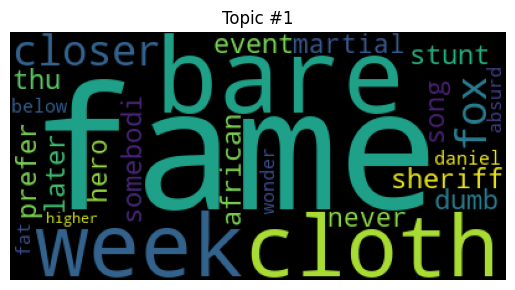

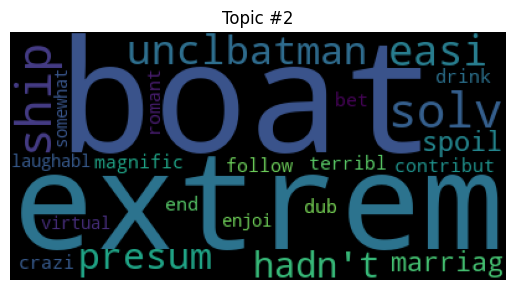

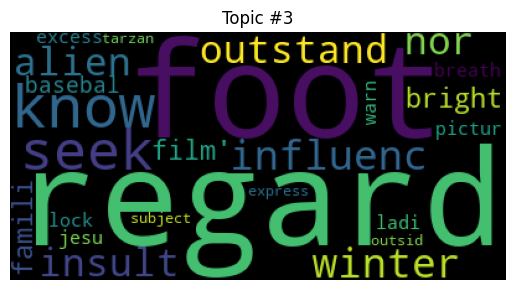

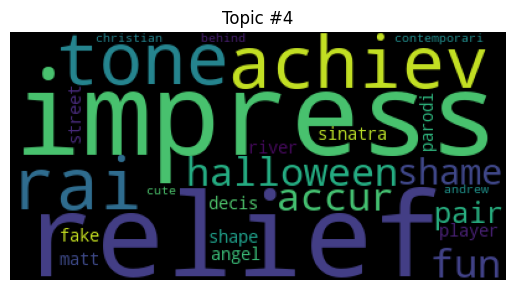

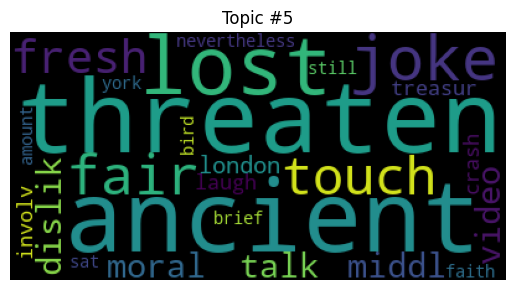

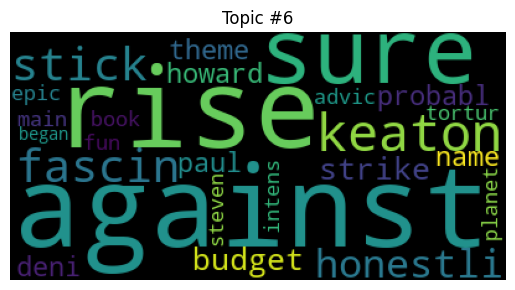

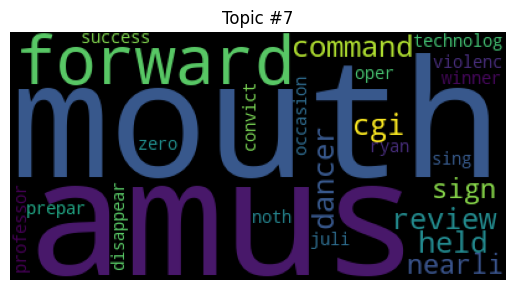

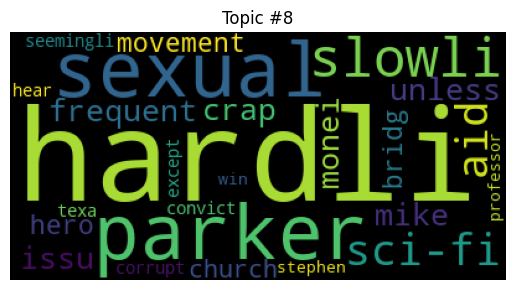

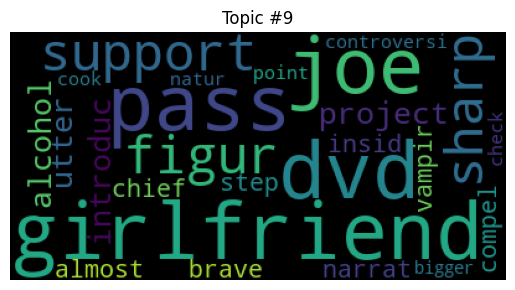

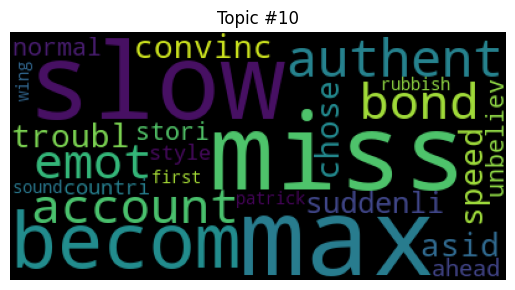

In [19]:
for t in range(lda_model.num_topics):
    topic_words = dict(lda_model.show_topic(t, topn=25))
    plt.figure()
    plt.imshow(WordCloud().generate_from_frequencies(topic_words))
    plt.axis("off")
    plt.title("Topic #" + str(t + 1))
    plt.show()
    

#### 5% credit. Remove the 100 most frequent words from the bag-of-words, regardless of sentiment. 
Then, repeat part a. Display the top-10 words for each topic and discuss what each of the 10 underlying topics may be, compared to those you obtained in part a.

In [20]:
# Get the 100 most frequent words
most_frequent_words = sorted(dictionary.dfs.items(), key=lambda x: x[1], reverse=True)[:100]
most_frequent_words = [dictionary.get(word_id) for word_id, freq in most_frequent_words]

# Remove the most frequent words from the corpus
new_corpus = [[word for word in doc if word not in most_frequent_words] for doc in corpus]

In [21]:
new_dictionary = corpora.Dictionary(new_corpus)
new_corpus_gensim = [new_dictionary.doc2bow(text) for text in new_corpus]

In [22]:
#new LDA model
lda_model = gensim.models.LdaMulticore(new_corpus_gensim, num_topics=10, id2word=new_dictionary, workers=6)

In [23]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[new_corpus_gensim]

[(0,
  '0.001*"caus" + 0.001*"earlier" + 0.001*"phone" + 0.001*"leav" + '
  '0.001*"soft" + 0.001*"cross" + 0.001*"imit" + 0.001*"new" + 0.001*"like" + '
  '0.001*"memori"'),
 (1,
  '0.001*"villain" + 0.001*"serious" + 0.001*"australian" + 0.001*"hint" + '
  '0.001*"situat" + 0.001*"associ" + 0.001*"glass" + 0.001*"boi" + 0.001*"cat" '
  '+ 0.001*"matur"'),
 (2,
  '0.001*"scale" + 0.001*"demon" + 0.001*"girlfriend" + 0.001*"patrick" + '
  '0.001*"fail" + 0.001*"depict" + 0.001*"slow" + 0.001*"con" + 0.001*"reach" '
  '+ 0.001*"top"'),
 (3,
  '0.001*"cast" + 0.001*"grab" + 0.001*"simpli" + 0.001*"son" + 0.001*"degre" '
  '+ 0.001*"entertain" + 0.001*"movement" + 0.001*"delight" + 0.001*"emotion" '
  '+ 0.001*"wish"'),
 (4,
  '0.001*"stereotyp" + 0.001*"escap" + 0.001*"episod" + 0.001*"difficult" + '
  '0.001*"solv" + 0.001*"tale" + 0.001*"ladi" + 0.001*"hope" + 0.001*"drop" + '
  '0.001*"class"'),
 (5,
  '0.001*"success" + 0.001*"work" + 0.001*"other" + 0.001*"part" + '
  '0.001*"oscar"

In [24]:
#display in 10x10 matrix with each column representing a topic
#the rows will hold the top 10 words for each topic

#for example, topic 1, topic 2, topic 3...topic 10
topics_matrix = [top_names(topic_number) for topic_number in range(10)]
topics_df = pd.DataFrame(topics_matrix)
#now do T of the matrix
topics_df = topics_df.transpose()
topics_df.columns = ['Topic '+str(i) for i in range(1,11)]
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,caus,villain,scale,cast,stereotyp,success,european,specif,kid,dougla
1,earlier,serious,demon,grab,escap,work,research,vision,captiv,dare
2,phone,australian,girlfriend,simpli,episod,other,europ,thrown,forgett,sing
3,leav,hint,patrick,son,difficult,part,chill,blond,heavi,handl
4,soft,situat,fail,degre,solv,oscar,green,melodrama,dread,fare
5,cross,associ,depict,entertain,tale,trilogi,late,fashion,chines,spanish
6,imit,glass,slow,movement,ladi,blame,gorgeou,graphic,potenti,imit
7,new,boi,con,delight,hope,west,church,theme,three,opinion
8,like,cat,reach,emotion,drop,slasher,price,listen,women,pilot
9,memori,matur,top,wish,class,common,fellow,genuin,gene,student


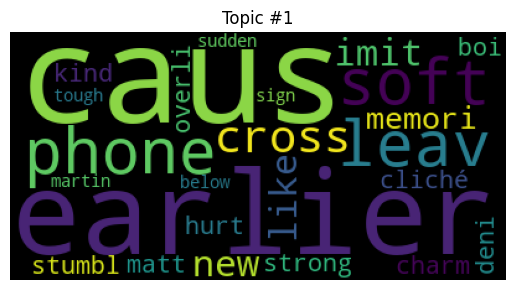

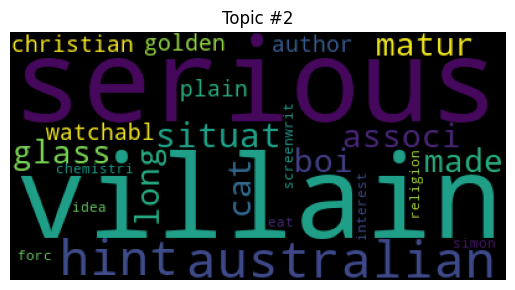

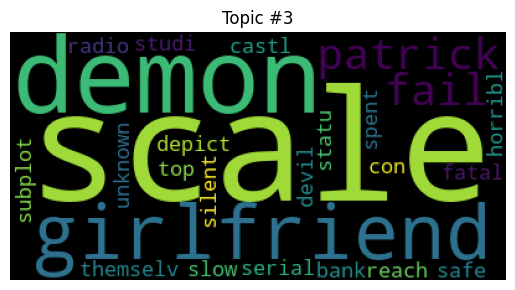

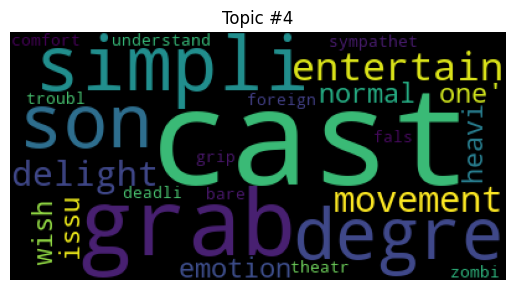

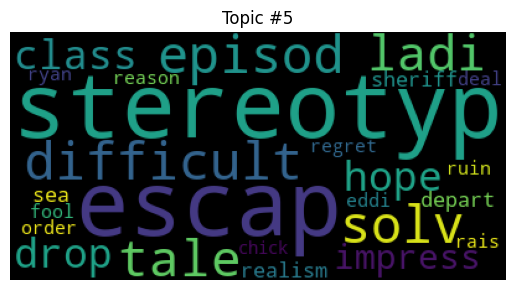

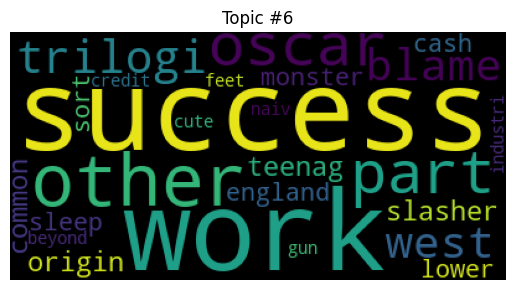

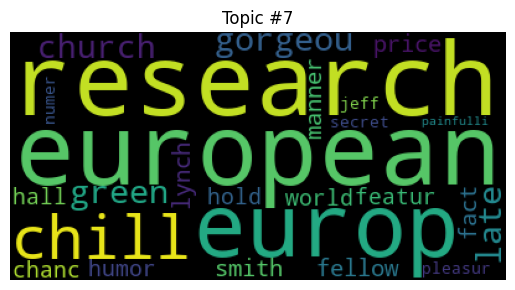

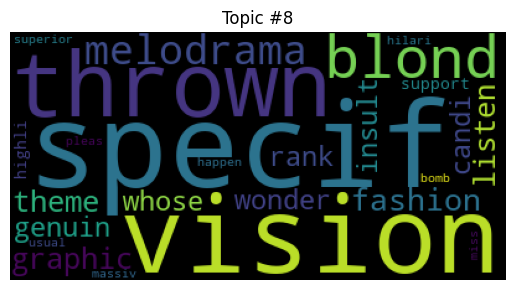

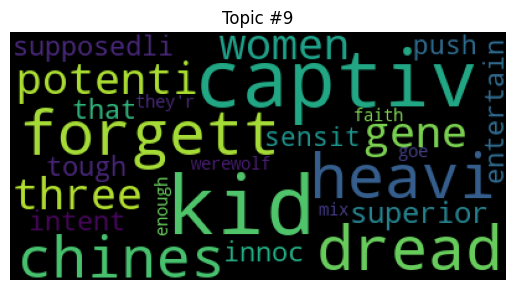

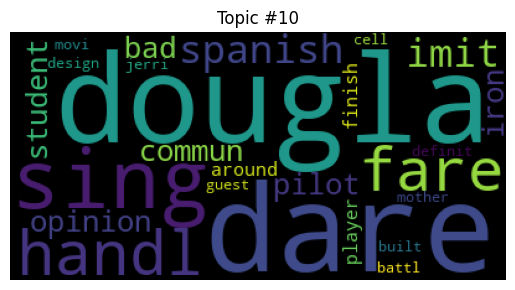

In [25]:
# Visualize the topics
for t in range(lda_model.num_topics):
    topic_words = dict(lda_model.show_topic(t, topn=25))
    plt.figure()
    plt.imshow(WordCloud().generate_from_frequencies(topic_words))
    plt.axis("off")
    plt.title("Topic #" + str(t + 1))
    plt.show()
    

#### 10% credit. Find the top 500 movie reviews for each topic in part b1, then compute the average sentiment of those 500 reviews. 
Does the average sentiment of each topic help you interpret those topics? Please elaborate.



In [26]:
#use the w_sentiment dataframe to get the sentiment for each review
#then use the topic distribution to get the top 500 reviews for each topic
#then average the sentiment for those 500 reviews

#first, get the topic distribution for each review and choose the topic with the highest probability
#this should be a 1d array of the topic with the highest probability for each review
topic = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in new_corpus_gensim]
# topic_dist = [lda_model.get_document_topics(doc) for doc in new_corpus_gensim]
# topic = [max(t, key=lambda x: x[1]) for t in topic_dist]


In [50]:
#turn topic into a dataframe
topic = pd.DataFrame(topic)
topic["ReviewID"] = range(1, len(topic) + 1)
topic.columns = ["Topic", "ReviewID"]

In [51]:
#now, get the topic with the highest probability for each review
#join with sentiment dataframe
topic_sentiment = pd.merge(sentiment, pd.DataFrame(topic), on="ReviewID")
topic_sentiment

,Sentiment,ReviewID,Topic
0,0,1,6
1,0,2,6
2,1,3,1
3,1,4,1
4,0,5,5
...,...,...,...
24993,0,24994,2
24994,0,24995,8
24995,0,24996,8
24996,0,24997,0


In [52]:
sum_sentiment = topic_sentiment.groupby("Topic").sum()
sum_sentiment = sum_sentiment.drop(columns=["ReviewID"])

In [53]:
#drop reviewID column
print(sum_sentiment)


       Sentiment
Topic           
0           1255
1           1303
2           1340
3           1141
4           1067
5           1164
6           1263
7           1263
8           1445
9           1257


In [54]:
#calculate the number of documents in each topic
num_docs = topic.groupby("Topic").count()
#concatenate with sum_sentiment
sum_sentiment = pd.concat([sum_sentiment, num_docs], axis=1)

In [55]:
sum_sentiment["Average Sentiment"] = sum_sentiment["Sentiment"]/sum_sentiment["ReviewID"]
sum_sentiment

,Sentiment,ReviewID,Average Sentiment
Topic,,,
0,1255,2466,0.508921
1,1303,2598,0.501540
2,1340,2635,0.508539
3,1141,2337,0.488233
4,1067,2185,0.488330
5,1164,2354,0.494477
6,1263,2499,0.505402
7,1263,2565,0.492398
8,1445,2841,0.508624


In [57]:
#sum items in ReviewID column
#change ReviewID column to "Number of Documents"
sum_sentiment = sum_sentiment.rename(columns={"ReviewID": "Number of Documents"})

In [58]:
#if the sentiment is > 500, avg sentiment for top 500 reviews is 1, else, it is the sentiment/500
sum_sentiment["Top 500"] = np.where(sum_sentiment["Sentiment"] > 500, 1, sum_sentiment["Sentiment"]/500)

In [59]:
sum_sentiment

,Sentiment,Number of Documents,Average Sentiment,Top 500
Topic,,,,
0,1255,2466,0.508921,1.0
1,1303,2598,0.501540,1.0
2,1340,2635,0.508539,1.0
3,1141,2337,0.488233,1.0
4,1067,2185,0.488330,1.0
5,1164,2354,0.494477,1.0
6,1263,2499,0.505402,1.0
7,1263,2565,0.492398,1.0
8,1445,2841,0.508624,1.0


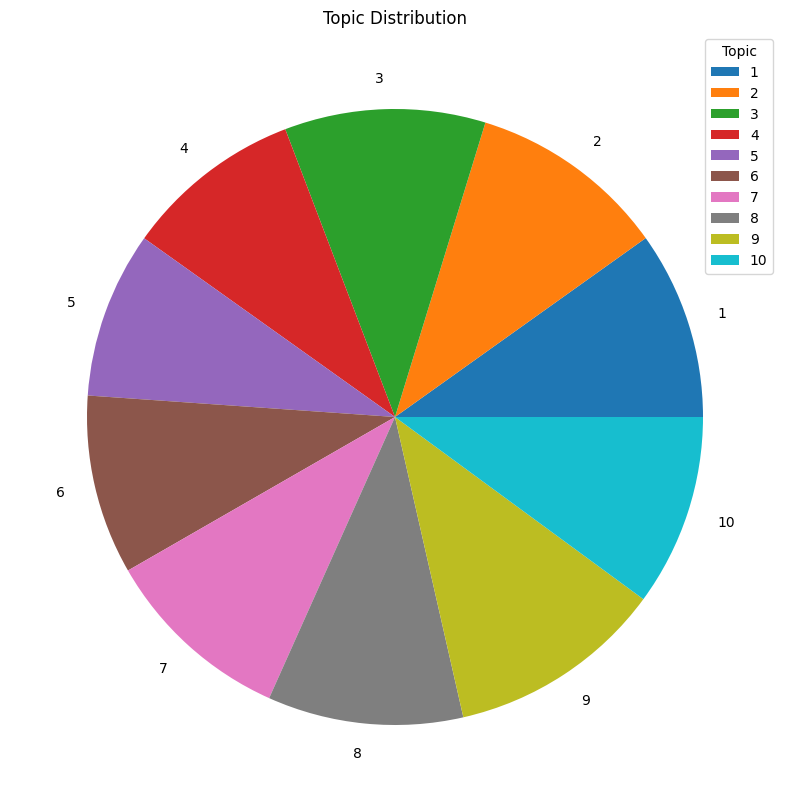

In [66]:
#make pie chart of topic distribution
plt.figure(figsize=(10,10))
plt.pie(sum_sentiment["Number of Documents"], labels=sum_sentiment.index + 1)
plt.legend(title="Topic")
plt.title("Topic Distribution")
plt.show()


In [35]:
x_ticks = ["Topic " + str(no) for no in range(1, 11)]

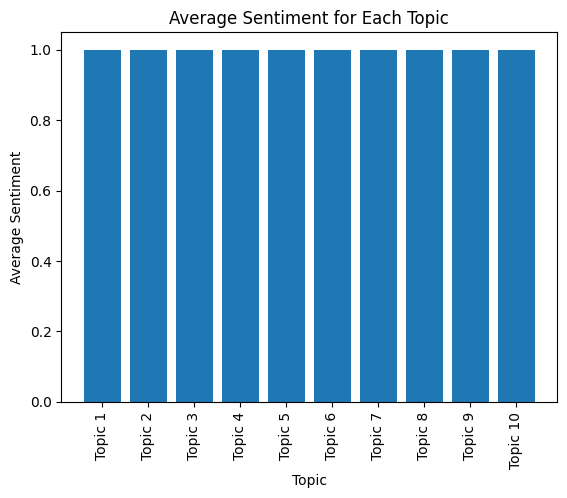

In [36]:
#plot avg sentiment for each topic
plt.bar(range(1,11), sum_sentiment["Top 500"])
plt.xlabel("Topic")
plt.xticks(range(1,11), x_ticks,rotation=90)
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment for Each Topic")
plt.show()

#### 10% credit. Split the corpus into two sets: X+ containing only positive reviews, and X containing only negative reviews. 
Then compute the tf-idf matrix for each set: M+ from X+ (roughly a 12,500✖2073 matrix), and M- from X- (~12,500✖2073). 

Next, compute the average tf-idf of each word in X+ (i.e., a 1✖2073 vector), and the average tf-idf of each word in X- (i.e., another 1✖2073 vector). 

Finally, compute the absolute value of the difference between the two vectors, and sort words by decreasing order. 
- Which words come at the top and at the bottom of the list? Can you interpret the result?


In [9]:
from sklearn.feature_extraction.text import TfidfTransformer

#split the corpus into positive and negative reviews
pos = [w_sentiment[w_sentiment["Sentiment"] == 1]]
neg = [w_sentiment[w_sentiment["Sentiment"] == 0]]

In [10]:
pos = pd.DataFrame(pos[0])
neg = pd.DataFrame(neg[0])

#drop the sentiment column
pos = pos.drop(columns=["Sentiment", "ReviewID"])
neg = neg.drop(columns=["Sentiment", "ReviewID"])

In [11]:
pos.shape

(12498, 2073)

In [12]:
#compute tfidf for positive reviews
tfidf_pos = TfidfTransformer()
tfidf_pos.fit(pos)
pos_tfidf = tfidf_pos.transform(pos)

#compute tfidf for negative reviews
tfidf_neg = TfidfTransformer()
tfidf_neg.fit(neg)
neg_tfidf = tfidf_neg.transform(neg)

#convert to dense matrix
pos_tfidf = pos_tfidf.todense()
neg_tfidf = neg_tfidf.todense()


In [13]:
pos_tfidf = pd.DataFrame(pos_tfidf)
pos_tfidf.columns = pos.columns
pos_tfidf

,1/2,True,abandon,abil,abl,absolut,absurd,abus,academi,accent,...,yeah,year,yet,york,young,younger,yourself,youth,zero,zombi
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.093232,...,0.0,0.046311,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.054424,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12493,0.0,0.0,0.0,0.000000,0.0,0.080088,0.0,0.0,0.110974,0.000000,...,0.0,0.052113,0.00000,0.0,0.000000,0.0,0.093431,0.0,0.0,0.0
12494,0.0,0.0,0.0,0.080148,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
12495,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.06073,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
12496,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [14]:
neg_tfidf = pd.DataFrame(neg_tfidf)
neg_tfidf.columns = neg.columns
neg_tfidf


,1/2,True,abandon,abil,abl,absolut,absurd,abus,academi,accent,...,yeah,year,yet,york,young,younger,yourself,youth,zero,zombi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.08388,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
12496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
12497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
12498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [15]:
# Next, compute the average tf-idf of each word in X+ (i.e., a 1✖2073 vector)
#average tf-idf of each word in X- (i.e., another 1✖2073 vector). 

avg_pos = pos_tfidf.mean(axis=0)
avg_neg = neg_tfidf.mean(axis=0)
print(avg_pos, "\n")
print(avg_neg)

1/2         0.001102
True        0.008964
abandon     0.001266
abil        0.002136
abl         0.004842
              ...   
younger     0.002472
yourself    0.003794
youth       0.002063
zero        0.001119
zombi       0.002766
Length: 2073, dtype: float64 

1/2         0.001957
True        0.005557
abandon     0.001232
abil        0.002283
abl         0.003961
              ...   
younger     0.001856
yourself    0.004814
youth       0.001242
zero        0.002553
zombi       0.006517
Length: 2073, dtype: float64


In [16]:
#Finally, compute the absolute value of the difference between the two vectors, and sort words by decreasing order. 
# - Which words come at the top and at the bottom of the list? Can you interpret the result?

diff = abs(avg_pos - avg_neg)
diff = pd.DataFrame(diff)
diff.columns = ["Difference"]

diff = diff.sort_values(by="Difference", ascending=False)

In [17]:
diff.head(20)

,Difference
bad,0.020346
worst,0.013283
great,0.013048
wast,0.012125
love,0.011676
movi,0.010160
bore,0.008675
just,0.008401
terribl,0.008313
even,0.008294


In [18]:
diff.tail(20)

,Difference
level,1.081589e-05
suspens,1.033767e-05
frustrat,1.017628e-05
brief,1.007696e-05
circumst,9.672764e-06
jone,8.973833e-06
break,8.870056e-06
bear,7.602515e-06
luck,6.955620e-06
camp,6.034626e-06


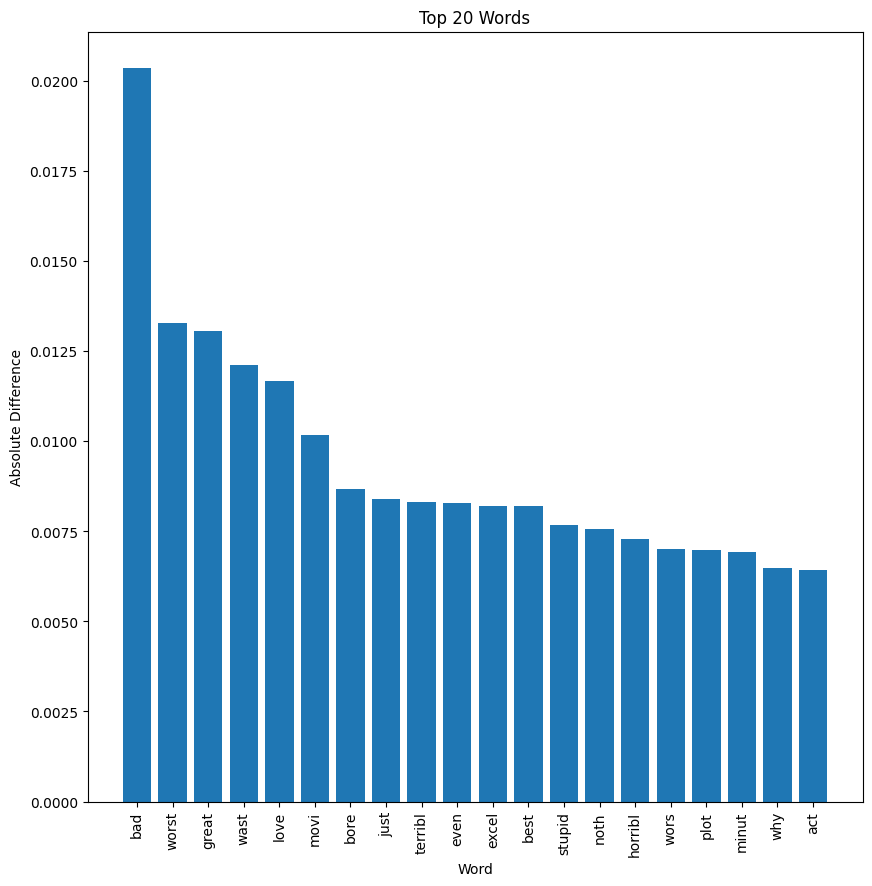

In [19]:
#display top 20 words in a bar chart
plt.figure(figsize=(10,10))
plt.bar(diff.head(20).index, diff.head(20)["Difference"])
plt.xlabel("Word")
plt.xticks(rotation=90)
plt.ylabel("Absolute Difference")
plt.title("Top 20 Words")
plt.show()

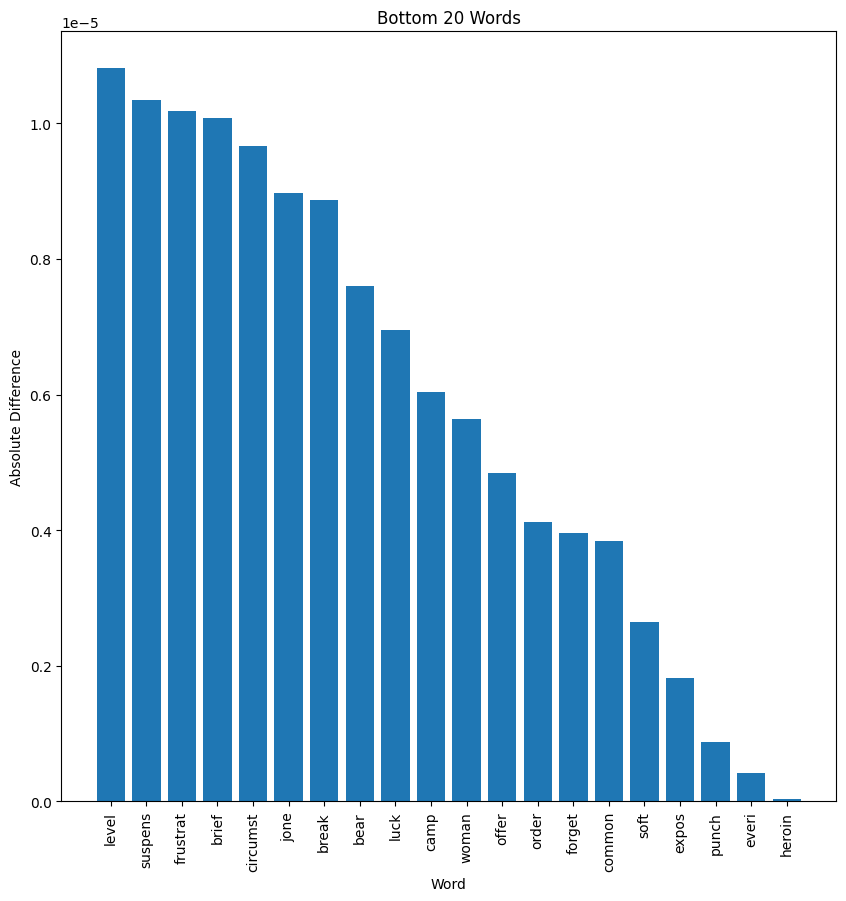

In [20]:
#plot the bottom 20 words
plt.figure(figsize=(10,10))
plt.bar(diff.tail(20).index, diff.tail(20)["Difference"])
plt.xlabel("Word")
plt.xticks(rotation=90)
plt.ylabel("Absolute Difference")
plt.title("Bottom 20 Words")
plt.show()
